In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import HomeMade as hm
import importlib
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score

In [10]:
N = 5e7

all_features = "v0_ks_mass v0_ks_massErr pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 \
v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p \
v0_ptErr \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks pseudorapidity trueKs ntrk_pv0".split(" ")

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
train_test_slice = int(len(data)*0.8)
train_data = data[:train_test_slice]
test_data = data[train_test_slice:]

In [11]:
model_features = ["v0_chi2 v0_py1 v0_phi1 v0_px1 v0_px v0_px2 v0_phi2 v0_py v0_py2 pv0_y pv0_x ntrk_pv0 pv0_z v0_z".split(" "),
                 "v0_rxyErr a0xy a0 cosTheta v0_x v0_y".split(" ")]

In [12]:
train_dividers = np.linspace(0,len(train_data),len(model_features)+1,dtype=int)
train_sets = [train_data[train_dividers[i-1]:train_dividers[i]] for i in range(1,len(train_dividers))]

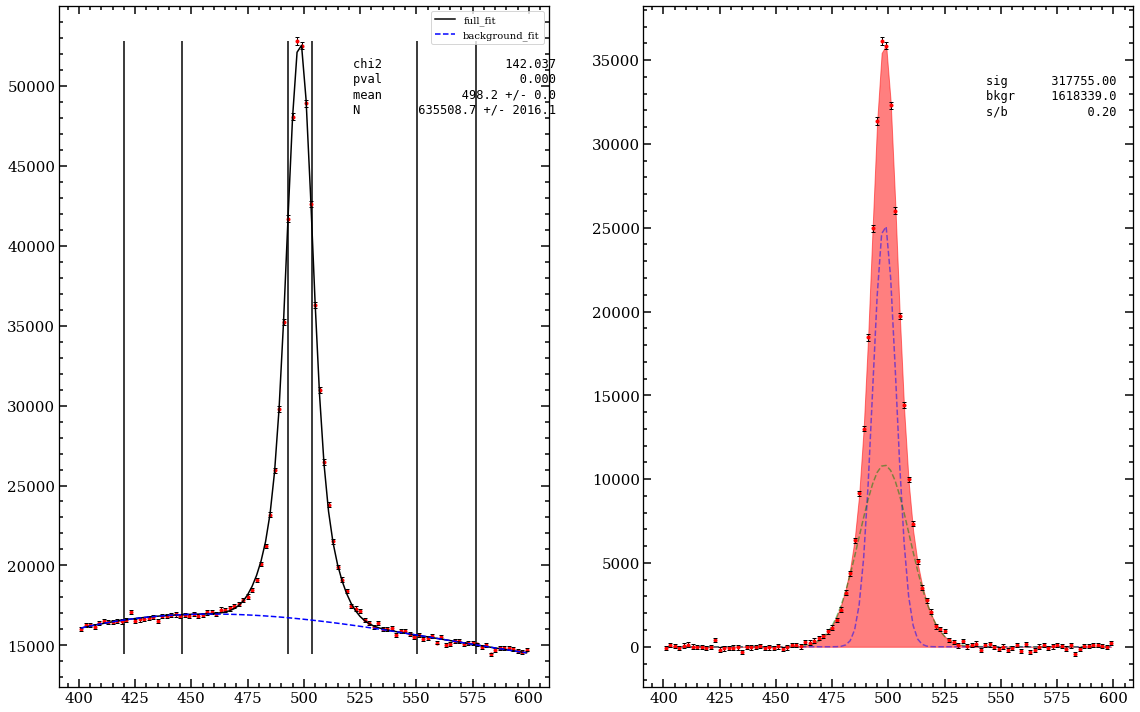

In [13]:
train_sets[0] = hm.assign_pseudolabels(train_sets[0])

In [14]:
classifiers = [xgb.XGBClassifier() for i in range(len(model_features))]
classifiers[0].fit(train_sets[0][model_features[0]],train_sets[0].y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [15]:
p0 = classifiers[0].predict_proba(train_sets[1][model_features[0]])[:,1]

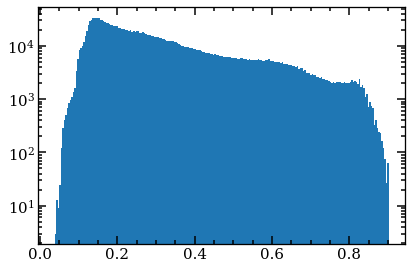

In [16]:
plt.hist(p0);
plt.yscale('log')

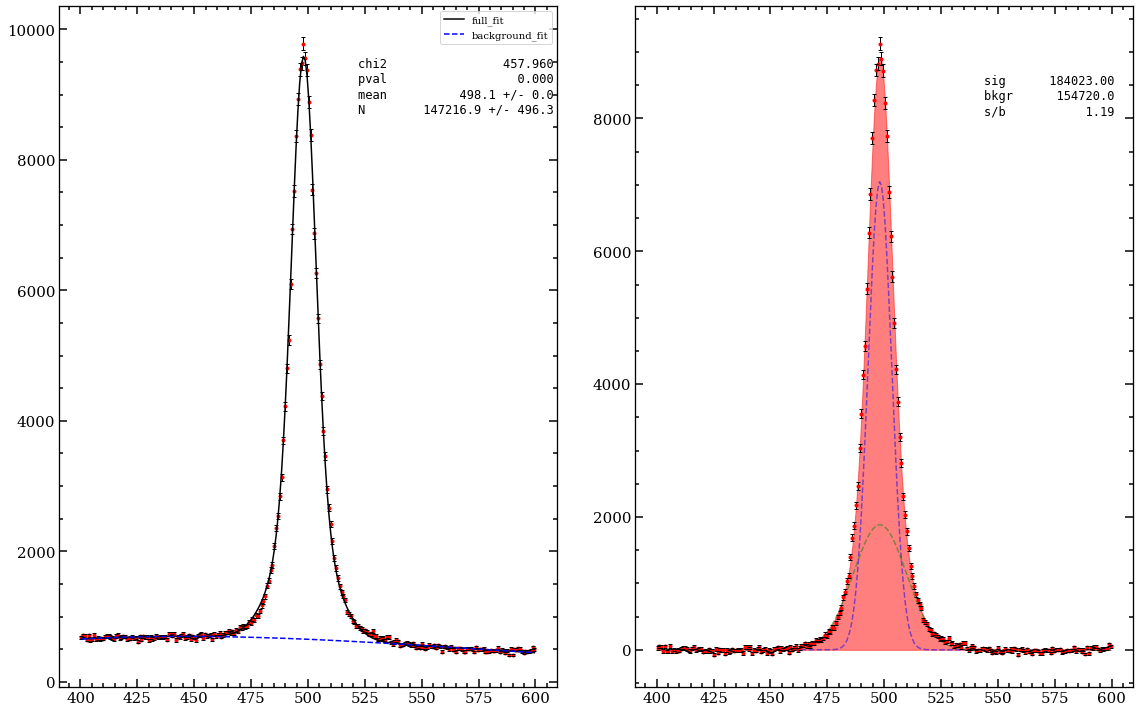

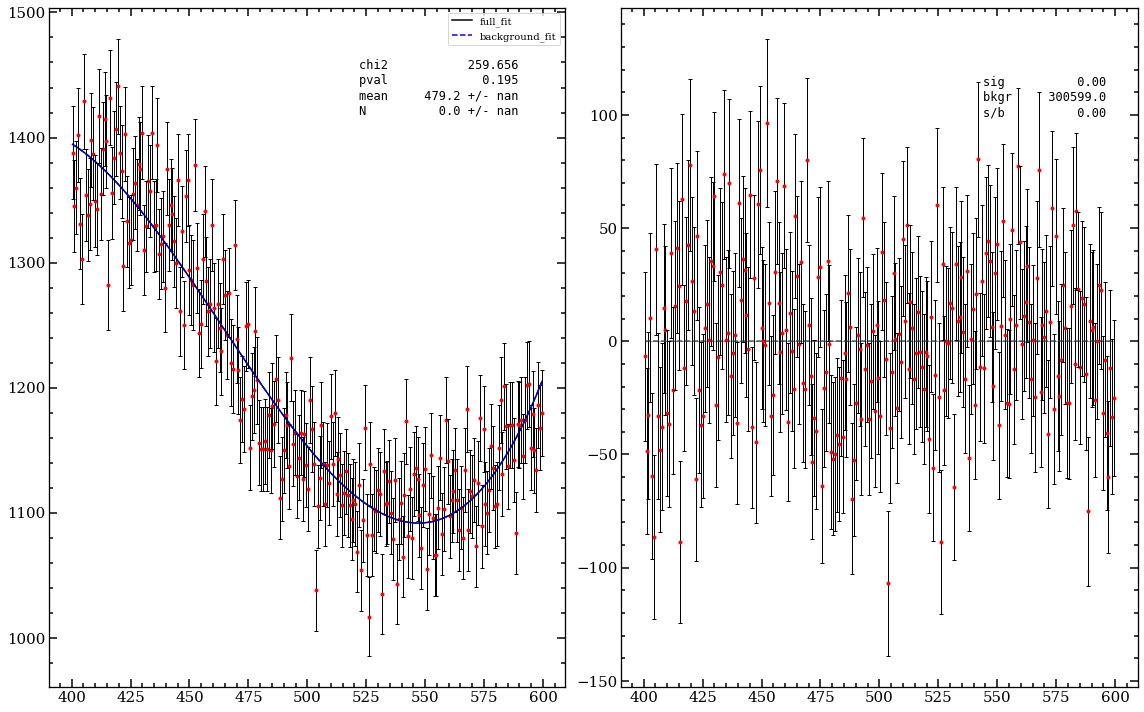

In [22]:
p_sig = 0.5
p_bkr = 0.15
vals, binc, binw = hm.hist(train_sets[1].loc[p0 > p_sig].v0_ks_mass,bins=250)
mask = vals > 0
d = hm.fit_mass2(binc[mask],vals[mask],np.sqrt(vals[mask]))

vals, binc, binw = hm.hist(train_sets[1].loc[p0 < p_bkr].v0_ks_mass,bins=250)
mask = vals > 0
d = hm.fit_mass2(binc[mask],vals[mask],np.sqrt(vals[mask]))

In [23]:
sig = train_sets[1].loc[(p0 > p_sig)&(train_sets[1].v0_ks_mass >475)&(train_sets[1].v0_ks_mass < 525)]
bkgr = train_sets[1].loc[p0 < p_bkr]
sig_len, bkgr_len = len(sig), len(bkgr)

train_sets[1] = pd.concat([sig,bkgr])
train_sets[1]['y'] = np.append(np.ones(sig_len),np.zeros(bkgr_len))

In [24]:
classifiers[1].fit(train_sets[1][model_features[1]],train_sets[1].y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [25]:
p1 = classifiers[1].predict_proba(test_data[model_features[1]])[:,1]

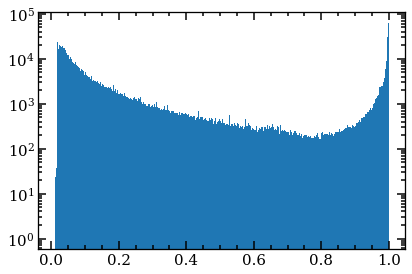

In [26]:
plt.hist(p1,bins=500);
plt.yscale('log')

No values, skipping..
No valid minimum found!
No valid minimum found!
No valid minimum found!
No background valid minimum found!
No background valid minimum found!
No background valid minimum found!
No background valid minimum found!
No valid minimum found!
No valid minimum found!
No background valid minimum found!
No valid minimum found!
No background valid minimum found!
No valid minimum found!
No valid minimum found!
No background valid minimum found!
No background valid minimum found!
No background valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No background valid minimum found!
No valid minimum found!
No background valid minimum found!
No valid minimum found!
No background valid minimum found!
No valid minimum found!
No background valid minimum found!
No background valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid

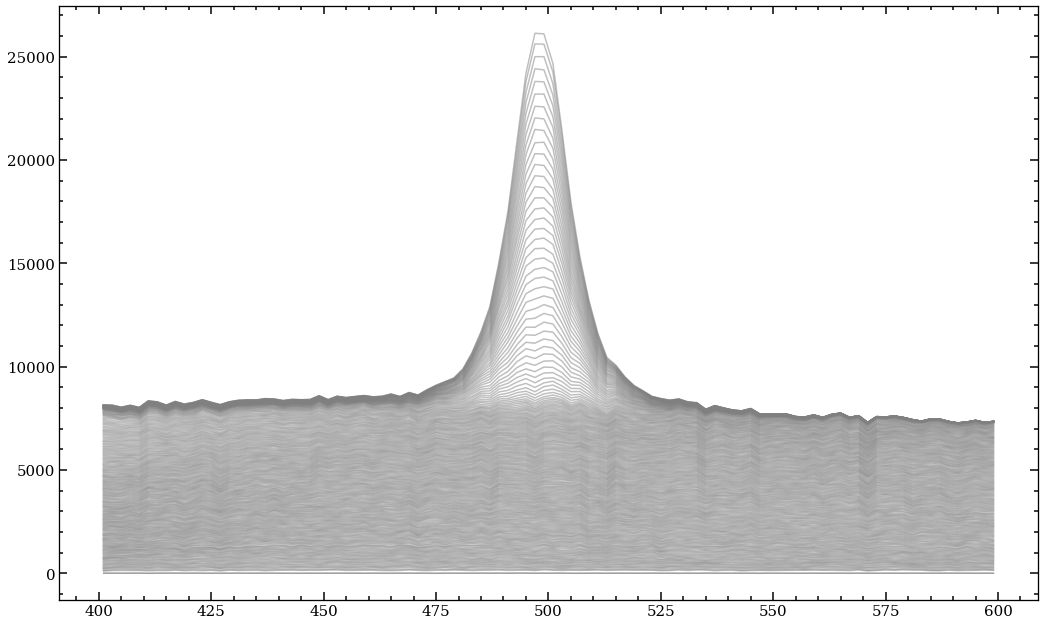

In [27]:
c = hm.ROC_data(test_data.v0_ks_mass, p1,thresholds = 200,plot_fit=False,plot_ROC=False)

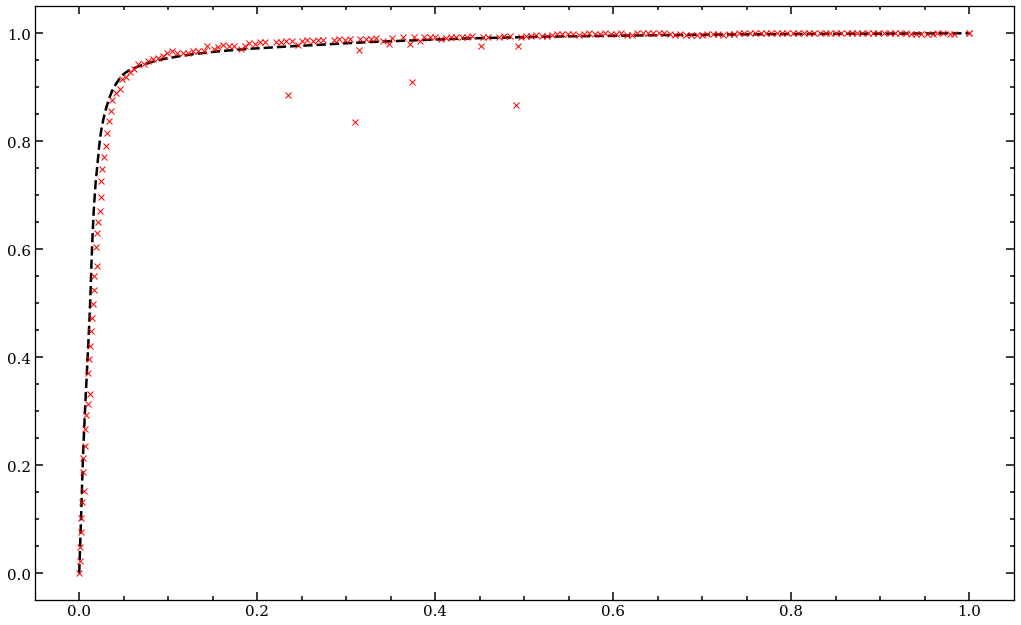

In [39]:
fpr = 1-c[1]/c[1].max()
tpr = 1-c[0]/c[0].max()
fpr_true, tpr_true, threshold = roc_curve(test_data.trueKs, p1)
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(fpr_true,tpr_true,'k--',linewidth=2.5)
ax.plot(fpr,tpr,'rx')

In [45]:
classifiers[1] = xgb.XGBClassifier()
classifiers[1].fit(train_sets[0][model_features[1]],train_sets[0].y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

No values, skipping..
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No background valid minimum found!
No background valid minimum found!
No background valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No background valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No background valid minimum found!
No valid minimum found!
No valid minimum found!
No valid minimum found!
No background valid minimum found!
No valid minimum found!
No valid minimum found!
No background valid minimum found!
No valid minimum found!
No valid minimum found!
No background valid minimum found!


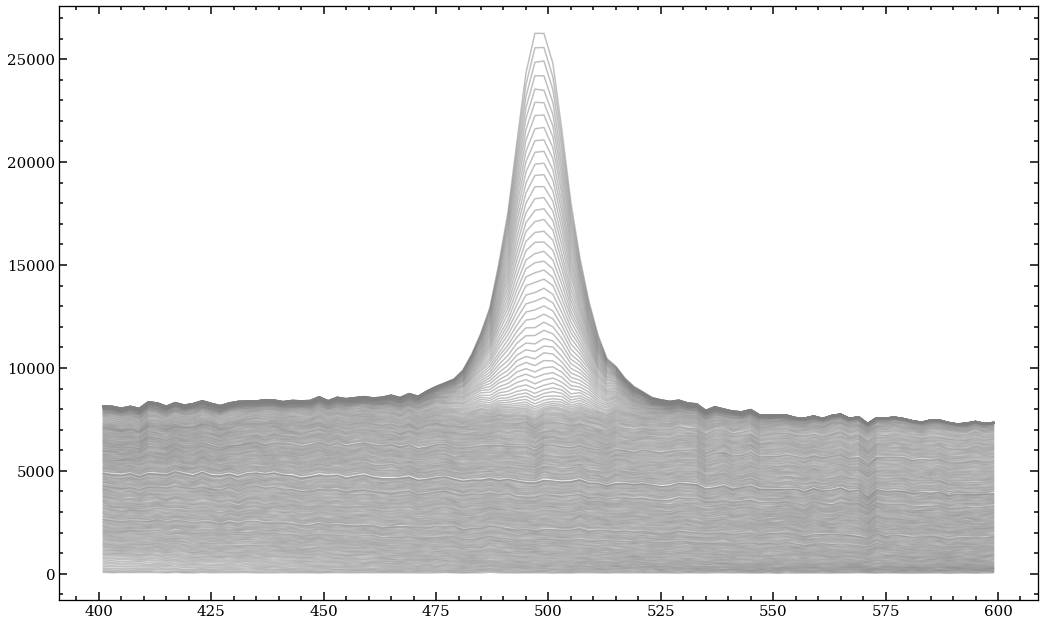

In [46]:
p2 = classifiers[1].predict_proba(test_data[model_features[1]])[:,1]
c = hm.ROC_data(test_data.v0_ks_mass,p2,thresholds = 200,plot_fit=False,plot_ROC=False)

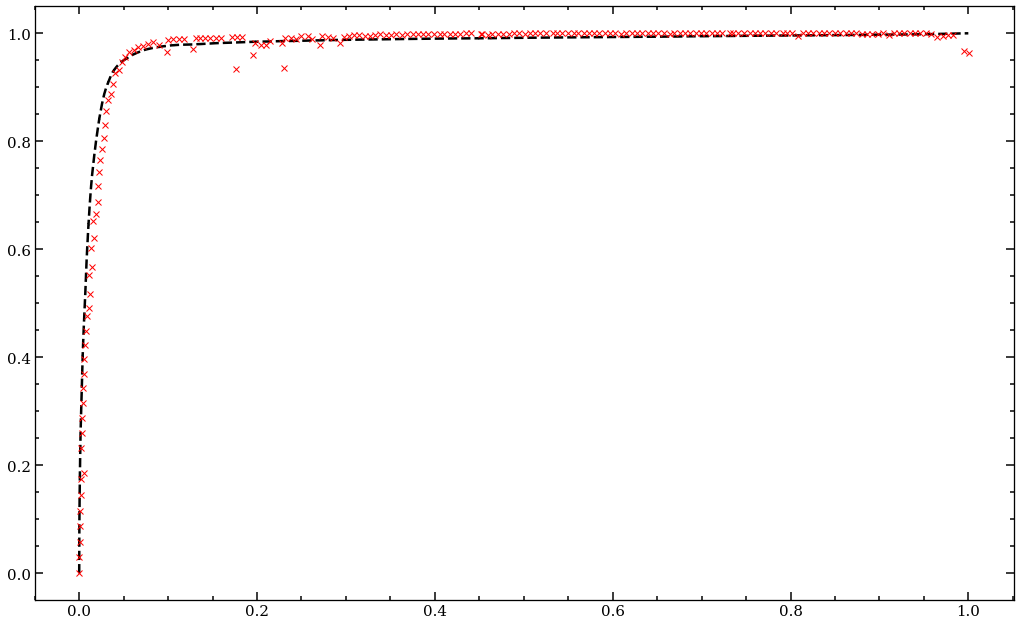

In [47]:
fpr = 1-c[1]/c[1].max()
tpr = 1-c[0]/c[0].max()
fpr_true, tpr_true, threshold = roc_curve(test_data.trueKs, p2)
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(fpr_true,tpr_true,'k--',linewidth=2.5)
ax.plot(fpr,tpr,'rx')